In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

In [36]:
img = cv2.imread('img1.png')
height, width, channel = img.shape
imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #bgr을 gray로 color convert

In [30]:
ret, thresh = cv2.threshold(imgray, 80, 255, 0)

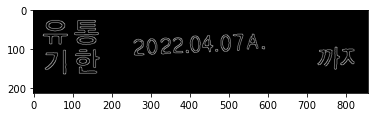

In [31]:
blur = cv2.GaussianBlur(imgray,(3,3),0) #노이즈 줄이기 위해 가우시안블러 사용
cv2.imwrite('img1.png',blur)
canny = cv2.Canny(blur,100,200)
cv2.imwrite('canny.jpg',canny)
plt.imshow(cv2.cvtColor(canny, cv2.COLOR_BGR2RGB))
plt.show()

In [37]:
contours, _ = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [50]:
contour_res = np.zeros((height, width, channel), dtype=np.uint8)
image = cv2.drawContours(contour_res, contours, -1, (0,255,0), 3)

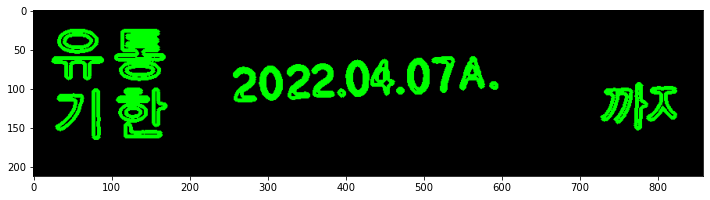

In [51]:
plt.figure(figsize=(12,10))
plt.imshow(image)

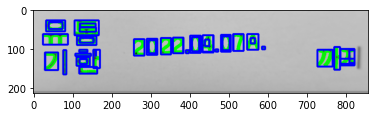

In [47]:
contour_dict = [] #찾기 쉽게 범위 데이터 저장하자

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour) #네모를 그려주자
    rectangle = cv2.rectangle(image, (x,y), (x+w, y+h), (0,0,255),2)
    contour_dict.append({
        'contour':contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w/2),
        'cy': y + (h/2)})
    
plt.imshow(rectangle)

### 유통기한 잡을 땐 ratio로 잡아야 할 것 같은 느낌 ?
--> 크기는 다 비슷하다...

In [85]:
MIN_AREA = 80 #숫자의 boundingrect의 최소 범위
MIN_WIDTH, MIN_HEIGHT = 2,10 #최소 너비와 높이
MINRATIO, MAX_RATIO = 0.25, 1.0 #가로대비 세로 비율

possible_contour = []

cnt = 0
for d in contour_dict:
    area = d['w']*d['h']
    ratio = d['w']/d['h']
    
    if area > MIN_AREA and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT and MINRATIO<ratio<MAX_RATIO:
        d['idx'] = cnt #인덱스 저장
        cnt +=1
        possible_contour.append(d)

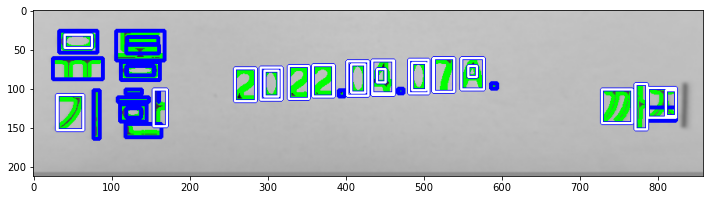

In [87]:
for d in possible_contour:
    cv2.rectangle(rectangle, (d['x'],d['y']), (d['x']+d['w'], d['y']+d['h']), (255,255,255), 2)
    
plt.figure(figsize=(12,10))
plt.imshow(rectangle, cmap='gray') #cmap: colormap

In [104]:
MAX_DIAG_MULTIPLYER = 5 #첫번째 다이얼로그? 대각선 길이의 5배 안에 다음 글자가 있어야 한다
MAX_ANGLE_DIFF = 12.0 # 두 글자의 중심 이은 그 각도? 가 이걸 넘지 말아라 아오
MAX_AREA_DIFF = 0.5 #두 글자의 면적 차이가 이만큼 넘지 말아라 제발
MAX_WIDTH_DIFF = 0.8 #너비차이 ㅡㅡ
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 5 #이 조건들을 만족하는 숫자들이 5개 미만이다? 그럼 탈락이야

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list: #첫번째 diag
        matched_contour_idx = []
        for d2 in contour_list: #두번째 diag
            if d1['idx'] == d2['idx']:
                continue
                
            
            dx = abs(d1['cx'] - d2['cx']) #d1과 d2사이의 가로 거리
            dy = abs(d1['cy'] - d2['cy']) #세로 거리
            
            diagonal_length1 = np.sqrt(d1['w']**2 + d1['h']**2) #중점 대각선 길이
            
            distance = np.linalg.norm(np.array([d1['cx'],d1['cy']]) - np.array([d2['cx'],d2['cy']]))
            # np.linalg.norm(a-b) : 벡터 a와 b사이의 거리를 구한다 
            
            if dx == 0: #dx가 0이면 세로로 있을 삘,, 유통기한이 세로로 정렬될 확률은.. 업따..
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy/dx))
                #dx/dy의 아크탄젠트 값을 구해주면 사이값 구할 수 있자나
            area_diff = abs(d1['w']*d1['h'] - d2['w']*d2['h'])/(d1['w']*d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contour_idx.append(d2['idx'])
            
            matched_contour_idx.append(d1['idx'])
            
            if len(matched_contour_idx) < MIN_N_MATCHED: #개수 5보다 작으면 continue.. 
                continue
            
            matched_result_idx.append(matched_contour_idx)
            
            unmatched_contour_idx = [] #아닌 것도 한번 비교
            
            for d4 in contour_list:
                if d4['idx'] not in matched_contour_idx: #matched아닌 애들 
                    unmatched_contour_idx.append(d4['idx'])
                    unmatched_contour = np.take(possible_contour, unmatched_contour_idx)
                    
            recursive_contour_list = find_chars(unmatched_contour)
            
            for idx in recursive_contour_list:
                matched_result_idx.append(idx)
            
            break
        return matched_result_idx
            
result_idx = find_chars(possible_contour)

matched_result = [] 
for idx_list in result_idx:
    matched_result.append(np.take(possible_contour, idx_list))

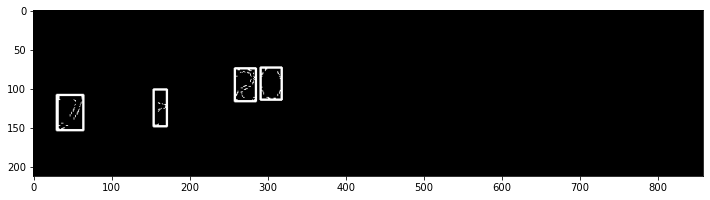

In [108]:
rectangle = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        for d in r:
            cv2.drawContours(rectangle, d['contour'], -1, (255, 255, 255))
            cv2.rectangle(rectangle, (d['x'], d['y']), (d['x']+d['w'], d['y']+d['h']), (255, 255, 255), 2)

plt.figure(figsize=(12,10))
plt.imshow(rectangle, cmap='gray')

# 삐뚤어진거 돌려놓자

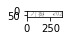

In [112]:
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2 #플레이트 정렬해주자 첨과 끝
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm( #빗변 구하기
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus)) #아크사인으로 각도 구함
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(thresh, M=rotation_matrix, dsize=(width, height))
    #warpaffine 으로 돌려놓기
    
    img_cropped = cv2.getRectSubPix( #그 부분만 잘라놓기
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
plt.subplot(len(matched_result), 1, i+1)
plt.imshow(img_cropped, cmap='gray')

In [120]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, (0, 0), 1.6, 1.6)
    plate_img, _ = cv2.threshold(plate_img, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _= cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \ # 최대최소 x y 구하고 
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0) #노이즈 한번 더 없애자
    img_result, _ = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU) #좀더 확시랗게 다시 쓰레시홀드
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    #패딩(여백) 주기 -> 잘 인식 할 수 있게

    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')
    #-psm 7 글자 한 줄, oem 0 : 0번 레거시 그냥 한글자씩 
    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-u4kjpz2z\opencv\modules\imgproc\src\resize.cpp:4054: error: (-215:Assertion failed) inv_scale_y > 0 in function 'cv::resize'


In [ ]:
''''''info = plate_infos[longest_idx]
chars = plate_chars[longest_idx]

print(chars)

img_out = img_ori.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)

cv2.imwrite(chars + '.jpg', img_out)

plt.figure(figsize=(12, 10))
plt.imshow(img_out)'''